In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

import sys
if '..' not in sys.path:
    sys.path.append('..')


import pandas as pd
import numpy as np
import networkx as nx
import copy
import scipy as sp
import math
import seaborn
import pickle
import warnings
import matplotlib
import re
# import multiprocessing

# from lib.mobilitysim import MobilitySimulator
from lib.dynamics import DiseaseModel
from lib.distributions import CovidDistributions
from lib.plot import Plotter
from lib.data import collect_data_from_df
from lib.measures import (
    MeasureList, 
    BetaMultiplierMeasure, 
    BetaMultiplierMeasureByType,
    SocialDistancingForAllMeasure, 
    SocialDistancingForKGroups,
    SocialDistancingByAgeMeasure,
    SocialDistancingForPositiveMeasure, 
    ComplianceForAllMeasure,
    Interval)
from lib.runutils import *
from IPython.display import display, HTML

# from lib.mobilitysim import MobilitySimulator
# from lib.town_data import generate_population, generate_sites, compute_distances
# from lib.town_maps import MapIllustrator

## Zihan

number of contacts: 5630.9
Tracking compliance 0.0, positive  53143
Tracking compliance 0.0, negative rate:  0.0
i_contained_infectious true rate:  1.0
number of contacts: 5447.25
Tracking compliance 1.0, positive  15897
Tracking compliance 1.0, negative rate:  0.0
i_contained_infectious true rate:  0.8643159251803768


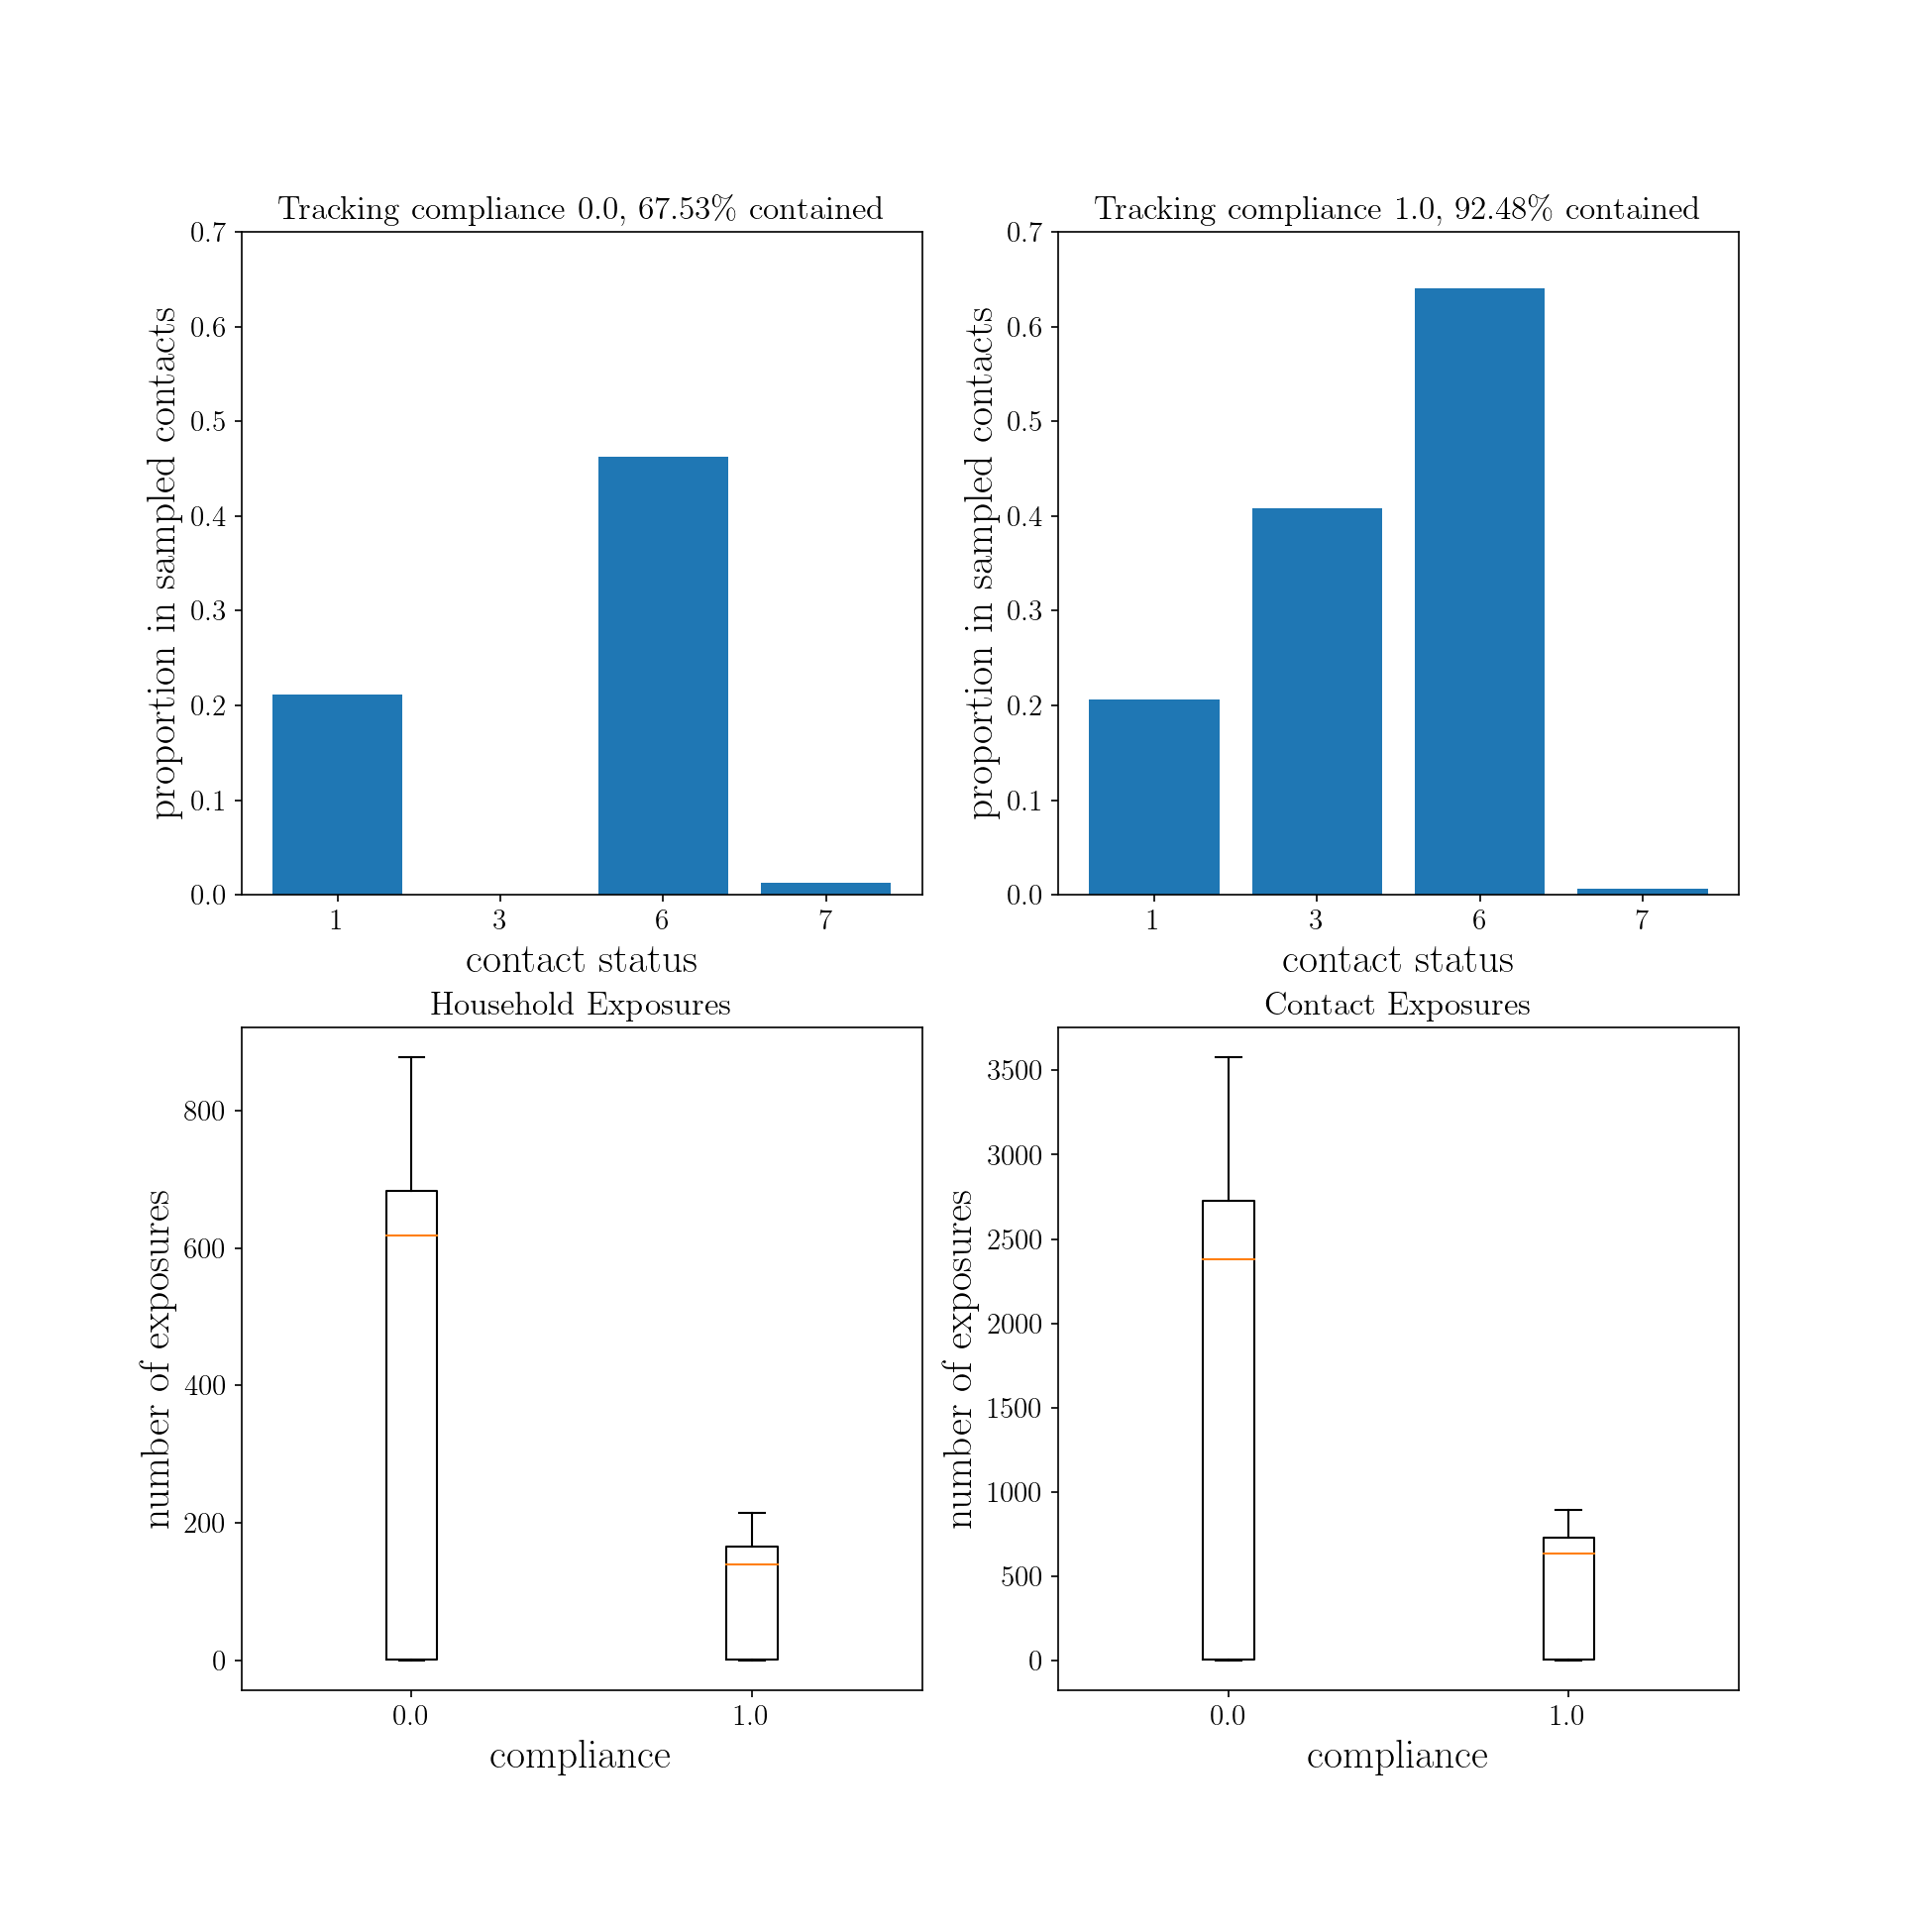

In [2]:
'''
(0) 0: SocialDistancingForAllMeasure`
(1) 1: SocialDistancingForPositiveMeasure
(2) 2: SocialDistancingByAgeMeasure`
(3) 3: SocialDistancingForSmartTracing
(4) 4: SocialDistancingForKGroups`
(5) 5: UpperBoundCasesSocialDistancing`
(6) 'resi/dead'
(7) 'hosp'
(8) 'site_measures'
(9) not contained
'''
import matplotlib.pyplot as plt
rpts = 20
p_compliance = [0.0, 1.0]
measures_deployed = [1,3,6,7]
summaries_SD_6 = load_summary('tracing_isolate_sftest_5trace_sup005_isohouse_40rpts_005betas_trace_all.pk')
for j, policy in enumerate(['advanced']):
    summaries_ = summaries_SD_6[policy]
    f,axs = plt.subplots(2,2,figsize = (13,13))
    num_expo_house = []
    num_expo_contact = []
    for s, summary in enumerate(summaries_):
        multi_3 = 0
        counts = np.zeros((10,))
        num_contacts = 0
        num_nega = np.sum(summary.state['nega'])
        num_posi = np.sum(summary.state['posi'])
        num_expo_house.append(summary.num_expo_house)
        num_expo_contact.append(summary.num_expo_contact)
        num_i_contained_infectious_true = 0
        num_j_contained_infectious_true = 0
        num_i_contained_infectious_false = 0
        num_j_contained_infectious_false = 0
        #axs[1,s].boxplot(summary.state_started_at['posi'][np.multiply(summary.state_started_at['posi']!=np.inf, summary.state_started_at['posi']!=-1)])
        for r in range(rpts):
            num_contacts += len(summary.mob[r])
            for contact in summary.mob[r]:
                if contact.data['i_contained_infectious']==True:
                    num_i_contained_infectious_true += 1
#                 if contact.data['j_contained_infectious']==True:
#                     num_j_contained_infectious_true += 1
                if contact.data['i_contained_infectious']==False:
                    num_i_contained_infectious_false += 1
#                 if contact.data['j_contained_infectious']==False:
#                     num_j_contained_infectious_false += 1
                if (not contact.data['i_contained']) and (not contact.data['j_contained'] ):
                    counts[9] += 1
                else:
#                     if (3 in contact.data['i_contained_by']) or (3 in contact.data['j_contained_by']):
#                         if len()
                    for i in range(6):
                        if (i in contact.data['i_contained_by']) or (i in contact.data['j_contained_by']):
                            counts[i] += 1
                    if ('resi/dead' in contact.data['i_contained_by']) or ('resi/dead' in contact.data['j_contained_by']):
                        counts[6] += 1
                    if ('hosp' in contact.data['i_contained_by']) or ('hosp' in contact.data['j_contained_by']):
                        counts[7] += 1
                    if ('site_measures' in contact.data['i_contained_by']) or ('site_measures' in contact.data['j_contained_by']):
                        counts[8] += 1
        counts /= num_contacts
        axs[0,s].bar(range(1,len(measures_deployed)+1),counts[measures_deployed])
        axs[0,s].set_title('Tracking compliance '+str(p_compliance[s])+', '+ str(round((1-counts[9])*100,2))+'\% contained')
        axs[0,s].set_xlabel('contact status',fontsize = 20)
        axs[0,s].set_ylabel('proportion in sampled contacts',fontsize = 20)
        axs[0,s].set_xticks(range(1,len(measures_deployed)+1))
        axs[0,s].set_xticklabels(measures_deployed)
        axs[0,s].set_ylim(0,0.7)
        
        
        print('number of contacts:', num_contacts/rpts)
        print('Tracking compliance '+str(p_compliance[s])+', positive ', num_posi)
        print('Tracking compliance '+str(p_compliance[s])+', negative rate: ', num_nega/(num_nega+num_posi))
        print('i_contained_infectious true rate: ',num_i_contained_infectious_true/(num_i_contained_infectious_true+num_i_contained_infectious_false))
        #print('j_contained_infectious true rate: ',num_j_contained_infectious_true/(num_j_contained_infectious_true+num_j_contained_infectious_false))
    axs[1,0].boxplot(num_expo_house)
    axs[1,0].set_title('Household Exposures')
    axs[1,0].set_xlabel('compliance',fontsize = 20)
    axs[1,0].set_xticklabels(p_compliance)
    axs[1,0].set_ylabel('number of exposures',fontsize = 20)
    axs[1,1].boxplot(num_expo_contact)
    axs[1,1].set_title('Contact Exposures')
    axs[1,1].set_xlabel('compliance',fontsize = 20)
    axs[1,1].set_xticklabels(p_compliance)
    axs[1,1].set_ylabel('number of exposures',fontsize = 20)
#plt.tight_layout()
plt.savefig('plots/tracing_isolate_sftest_5trace_sup005_isohouse_40rpts_005betas_trace_all_detail.png',dpi=300)
plt.show()

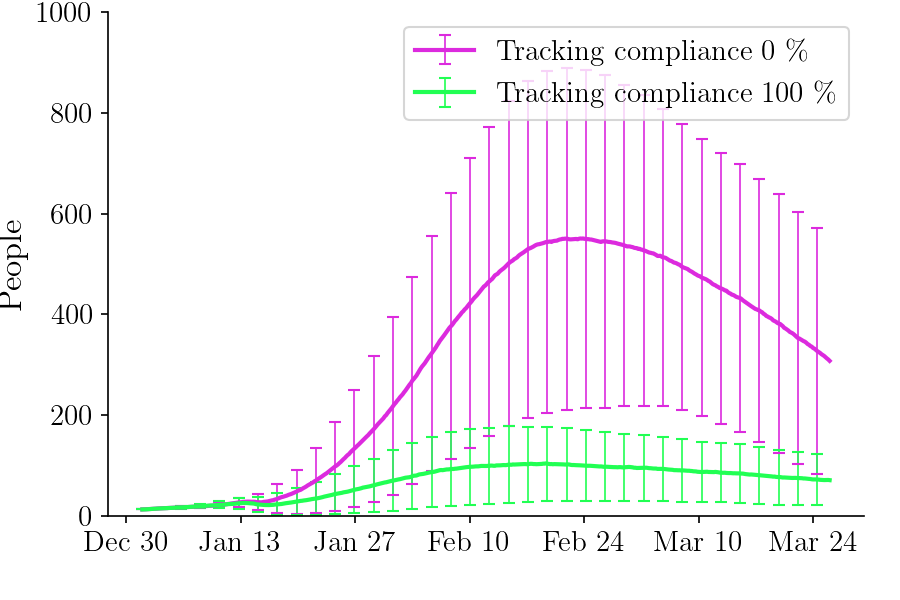

In [3]:
# Plot results of experiments_server_7-1.py
c=0
runstr = f'run{c}_'
summaries_SD_6 = load_summary('tracing_isolate_sftest_5trace_sup005_isohouse_40rpts_005betas_trace_all.pk')
FIGSIZE=(6, 4)

p_compliance = [0.0, 1.0]
plotter = Plotter()
titles_SD_6_ = list(['Tracking compliance '+ str(int(p*100.0)) + ' \%' for p in p_compliance])
for j, policy in enumerate(['advanced']):
    summaries_ = summaries_SD_6[policy]
    plotter.compare_total_infections(
        summaries_, 
        titles=titles_SD_6_, 
        figtitle=(f'Infections for compliance levels for ' + policy + ' individuals compliant with contact-tracing'),
        filename=runstr + f'SD_6{j}'+'tracing_isolate_sftest_5trace_sup005_isohouse_40rpts_005betas_trace_all', 
        figsize=FIGSIZE, acc=500, 
        ymax=1000, errorevery=14)

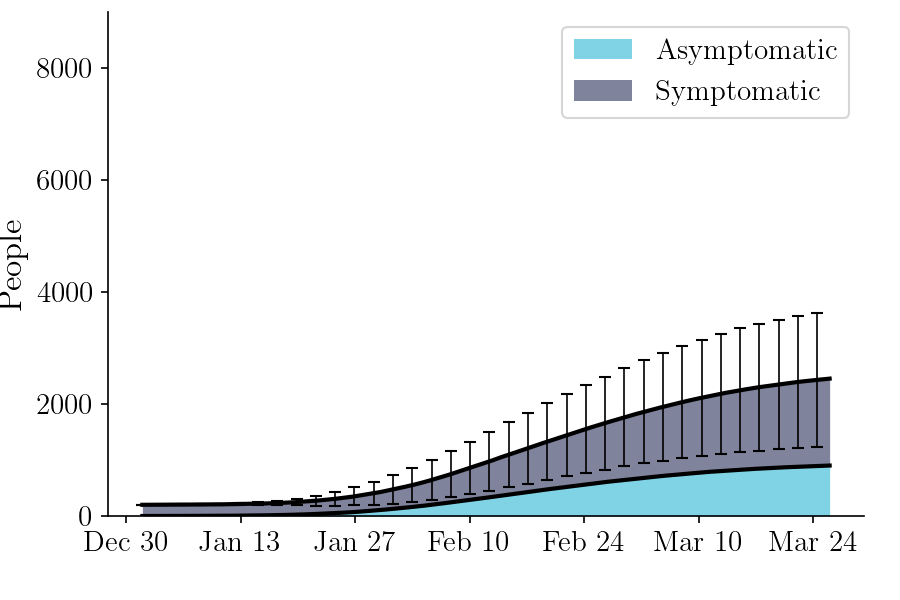

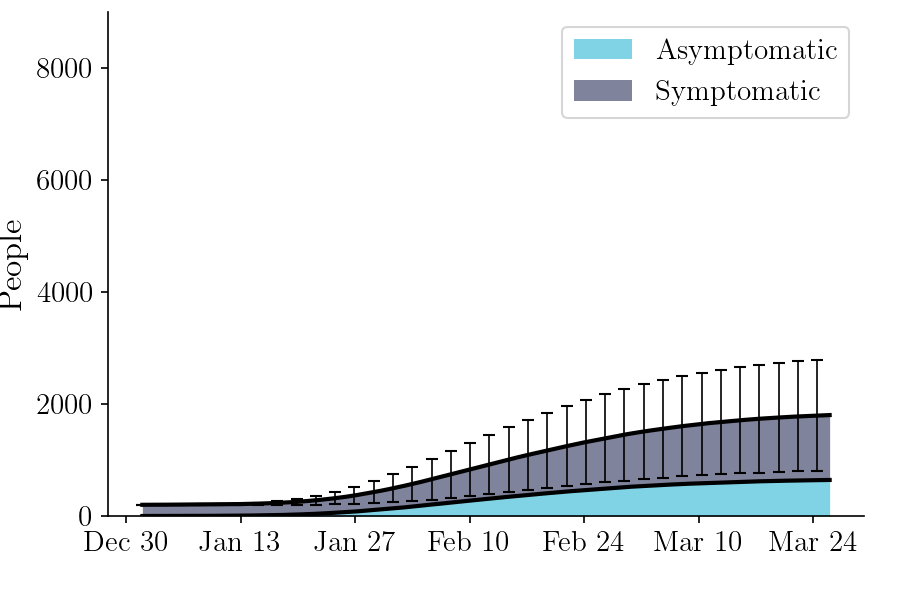

In [4]:
# Plot results of experiments_server_7-1.py
c=0
runstr = f'run{c}_'
summaries_SD_6 = load_summary('tracing_isolate_sftest_5trace_sup005_isohouse_40rpts_005betas_trace_friends_only.pk')
FIGSIZE=(6, 4)

p_compliance = [0.0, 1.0]
plotter = [Plotter() for i in range(len(p_compliance))]
titles_SD_6_ = list(['Tracking compliance '+ str(int(p*100.0)) + ' \%' for p in p_compliance])
for j, policy in enumerate(['advanced']):
    summaries_ = summaries_SD_6[policy]
    for i in range(len(p_compliance)):
        summary_ = summaries_[i]
        plotter[i].plot_cumulative_infected(
            summary_, 
            title=titles_SD_6_[i],
            filename=runstr + f'SD_6{i}_cum_'+'tracing_isolate_sftest_5trace_sup005_isohouse_40rpts_005betas_trace_friends_only', 
            figsize=FIGSIZE, acc=500, 
            ymax=9000, errorevery=14)

## Laura
### Experiments_server_7-1 with essential workers

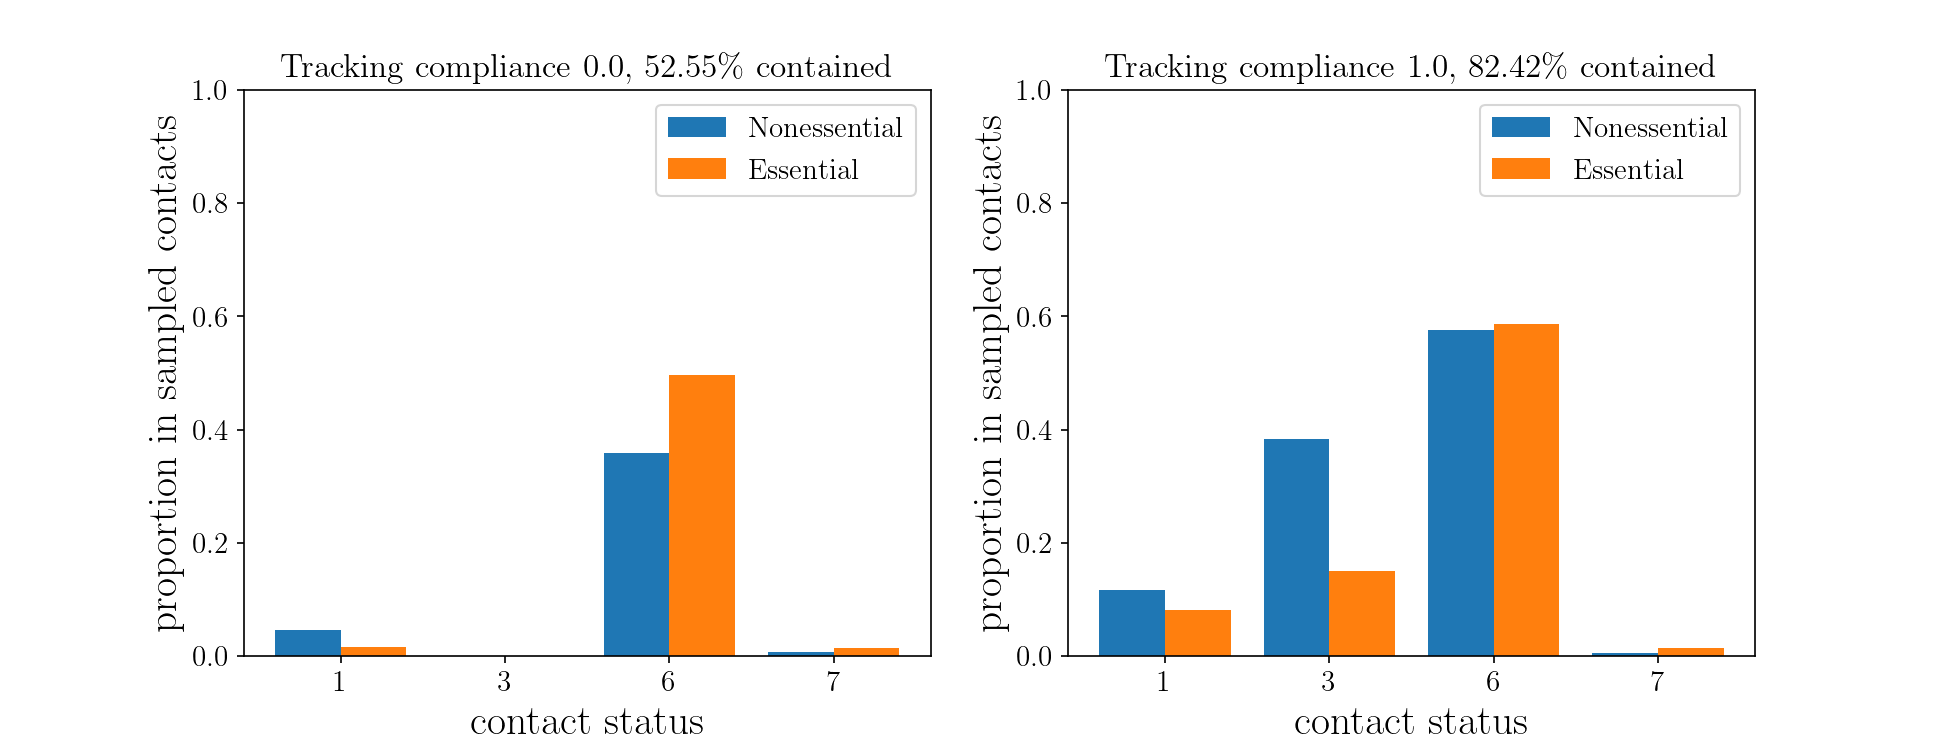

In [3]:
'''
(0) 0: SocialDistancingForAllMeasure`
(1) 1: SocialDistancingForPositiveMeasure
(2) 2: SocialDistancingByAgeMeasure`
(3) 3: SocialDistancingForSmartTracing
(4) 4: SocialDistancingForKGroups`
(5) 5: UpperBoundCasesSocialDistancing`
(6) 'resi/dead'
(7) 'hosp'
(8) 'site_measures'
(9) not contained
'''
import matplotlib.pyplot as plt
p_compliance = [0.0, 1.0]
measures_deployed = [1,3,6,7]
summaries_SD_6 = load_summary('summaries_contacts_supermarket_bh0.pk')
for j, policy in enumerate(['advanced']):
    summaries_ = summaries_SD_6[policy]
    f,axs = plt.subplots(1,2,figsize = (13,5))
    for s, summary in enumerate(summaries_):
        essential_counts = np.zeros((10,))
        essential_num_contacts = 0
        nonessential_counts = np.zeros((10,))
        nonessential_num_contacts = 0
        for r in range(summary.random_repeats):
            for contact in summary.mob[r]:
                if (summary.essential_workers[0][contact.indiv_j]==True):
                    essential_num_contacts += 1
                    counts = essential_counts
                else:
                    nonessential_num_contacts += 1
                    counts = nonessential_counts
                    
                if (not contact.data['i_contained']) and (not contact.data['j_contained'] ):
                    counts[9] += 1
                else:
                    for i in range(6):
                        if (i in contact.data['i_contained_by']) or (i in contact.data['j_contained_by']):
                            counts[i] += 1
                    if ('resi/dead' in contact.data['i_contained_by']) or ('resi/dead' in contact.data['j_contained_by']):
                        counts[6] += 1
                    if ('hosp' in contact.data['i_contained_by']) or ('hosp' in contact.data['j_contained_by']):
                        counts[7] += 1
                    if ('site_measures' in contact.data['i_contained_by']) or ('site_measures' in contact.data['j_contained_by']):
                        counts[8] += 1
        
        essential_counts /= essential_num_contacts
        nonessential_counts /= nonessential_num_contacts
        width = 0.4
        xticks = np.arange(1,len(measures_deployed)+1)
        axs[s].bar(xticks-0.2,nonessential_counts[measures_deployed],width=width, label='Nonessential')
        axs[s].bar(xticks+0.2,essential_counts[measures_deployed],width=width, label='Essential')
        axs[s].set_title('Tracking compliance '+str(p_compliance[s])+', '+ str(round((1-counts[9])*100,2))+'\% contained')
        axs[s].set_xlabel('contact status',fontsize = 20)
        axs[s].set_ylabel('proportion in sampled contacts',fontsize = 20)
        axs[s].set_xticks(range(1,len(measures_deployed)+1))
        axs[s].set_xticklabels(measures_deployed)
        axs[s].set_ylim(0,1.0)
        axs[s].legend()
#plt.tight_layout()
#plt.savefig('plots/contact_details.png',dpi=300)
plt.show()

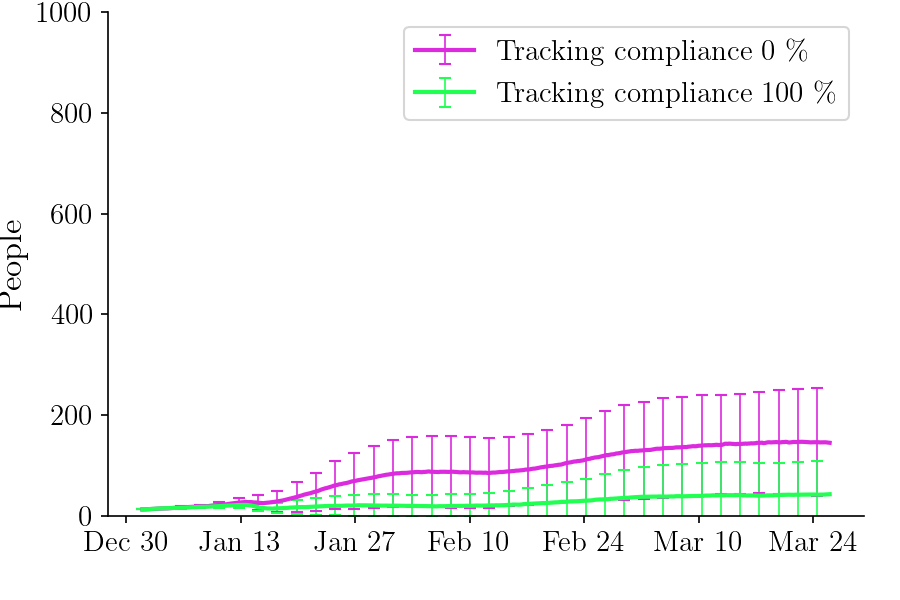

In [4]:
# Graph num infected
c=0
runstr = f'run{c}_'
# summaries_SD_6 = load_summary('contact_record_test_1.pk')
FIGSIZE=(6, 4)

p_compliance = [0.0, 1.0]
plotter = Plotter()
titles_ = list(['Tracking compliance '+ str(int(p*100.0)) + ' \%' for p in p_compliance])
for j, policy in enumerate(['advanced']):
    summaries_list = summaries_SD_6[policy]
    plotter.compare_total_infections(
        summaries_list, 
        titles=titles_, 
        filename=runstr + f'experiments_7-1', 
        figsize=FIGSIZE, acc=500, 
        ymax=1000, errorevery=14)

In [5]:
for summ in summaries_SD_6['advanced']:
    df = make_summary_df(summ)
    display(df)

,Total,Nonessential,Essential
num_people,4254,2121,2133
num_infected,882.3,533.025,349.275
pct_infected,20.7%,25.1%,16.4%
num_contacts,678.3,462.25,216.05


,Total,Nonessential,Essential
num_people,4254,2121,2133
num_infected,401.05,240.75,160.3
pct_infected,9.4%,11.4%,7.5%
num_contacts,197.1,149.7,47.4


### Experiments_essential.py

In [ ]:
# Plot results of experiments_essential.py
'''
(0) 0: SocialDistancingForAllMeasure`
(1) 1: SocialDistancingForPositiveMeasure
(2) 2: SocialDistancingByAgeMeasure`
(3) 3: SocialDistancingForSmartTracing
(4) 4: SocialDistancingForKGroups`
(5) 5: UpperBoundCasesSocialDistancing`
(6) 'resi/dead'
(7) 'hosp'
(8) 'site_measures'
(9) not contained
'''
measures = np.array(['SDForAll', 'SDForPositive', 'SDByAge', 'SDForSmartTracing','SDForKGroups','UpperBound','resi/dead','hosp','site_measures','not contained'])

import matplotlib.pyplot as plt
p_compliance = [0.0, 0.5]
measures_deployed = [1,3,6,7]
summaries_ = load_summary('summaries_r45.pk')

f,axs = plt.subplots(2,2,figsize = (13,10))
for j, policy in enumerate(['random','essential']):
    for s in range(len(p_compliance)):
        summary = summaries_[(policy,p_compliance[s])]
        essential_counts = np.zeros((10,))
        essential_num_contacts = 0
        nonessential_counts = np.zeros((10,))
        nonessential_num_contacts = 0
        for r in range(summary.random_repeats):
            for contact in summary.mob[r]:
                if (summary.essential_workers[0][contact.indiv_j]==True):
                    essential_num_contacts += 1
                    counts = essential_counts
                else:
                    nonessential_num_contacts += 1
                    counts = nonessential_counts
                    
                if (not contact.data['i_contained']) and (not contact.data['j_contained'] ):
                    counts[9] += 1
                else:
                    for i in range(6):
                        if (i in contact.data['i_contained_by']) or (i in contact.data['j_contained_by']):
                            counts[i] += 1
                    if ('resi/dead' in contact.data['i_contained_by']) or ('resi/dead' in contact.data['j_contained_by']):
                        counts[6] += 1
                    if ('hosp' in contact.data['i_contained_by']) or ('hosp' in contact.data['j_contained_by']):
                        counts[7] += 1
                    if ('site_measures' in contact.data['i_contained_by']) or ('site_measures' in contact.data['j_contained_by']):
                        counts[8] += 1
        
        essential_counts /= essential_num_contacts
        nonessential_counts /= nonessential_num_contacts
        width = 0.4
        xticks = np.arange(1,len(measures_deployed)+1)
        axs[j,s].bar(xticks-0.2,nonessential_counts[measures_deployed],width=width, label='Nonessential')
        axs[j,s].bar(xticks+0.2,essential_counts[measures_deployed],width=width, label='Essential')
        axs[j,s].set_title('Tracking compliance '+str(p_compliance[s])+', '+ str(round((1-counts[9])*100,2))+'\% contained')
        axs[j,s].set_xlabel('contact status',fontsize = 20)
        axs[j,s].set_ylabel('proportion in sampled contacts',fontsize = 20)
        axs[j,s].set_xticks(range(1,len(measures_deployed)+1))
        axs[j,s].set_xticklabels(measures[measures_deployed],rotation=45,ha='right',fontsize=10)
        axs[j,s].set_ylim(0,1.0)
        axs[j,s].legend()
plt.tight_layout()
#plt.savefig('plots/contact_details.png',dpi=300)
plt.show()

In [ ]:
c=0
runstr = f'run{c}_'
# summaries_ = load_summary('contact_record_test_1.pk')
FIGSIZE=(6, 4)

params = [('random',0.0),('random',0.5),('essential',0.5)]
plotter = Plotter()
titles_ = list(['Compliance '+ str(int(p*100.0)) + ' \%'+' '+policy for (policy, p) in params])
summaries_list = [summaries_[param] for param in params]
plotter.compare_total_infections(
    summaries_list, 
    titles=titles_, 
    filename=runstr + f'experiments_essential', 
    figsize=FIGSIZE, acc=500, 
    ymax=2000, errorevery=14)

In [ ]:
for summ in summaries_list:
    df = make_summary_df(summ)
    display(df)

## Deprecated

In [3]:
## Deprecated
# Plot results of experiments_server_6-1.py
summaries_SD_5 = load_summary('summaries_r12.pk')

start_date = '2020-03-08'
end_date = '2020-03-27'

isolation_days = [7] # how many days selected people have to stay in isolation
contacts_isolated = [10,25] # how many contacts are isolated in the `test_smart_delta` window
duration_weeks_SD_5 = 12 # strategies tested for 12 weeks starting today
FIGSIZE=(6, 4)
c=0
runstr = f'run{c}_'

plotter = Plotter()
for i, days in enumerate(isolation_days):
    for j, contacts in enumerate(contacts_isolated):
        summaries_ = summaries_SD_5[(days, contacts)]
        titles_SD_5_ = ['No contact tracing', 'Basic contact tracing', 'Advanced contact tracing']
        plotter.compare_total_infections(
            summaries_,
            start_date=start_date,
            titles=titles_SD_5_, 
            figtitle=(f'Strategies for isolating {contacts} contacts.\n'
                      f'Selected people are isolated for {days} days.'),
            filename=runstr + f'SD_5{i}{j}', 
            figsize=FIGSIZE, acc=500, 
            ymax=5000, errorevery=14)

FileNotFoundError: [Errno 2] No such file or directory: 'summaries/summaries_r12.pk'